In [2]:
from astropy.io import fits

# Open with ignore_missing_simple=True
hdu_list = fits.open('../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')

# Check contents
print(hdu_list.info())

# Access the first table
data = hdu_list[1].data  
print(data.columns)  # see column names

Filename: ../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   
None
ColDefs(
    name = 'x'; format = 'E'
    name = 'y'; format = 'E'
    name = 'z'; format = 'E'
    name = 'A_O'; format = 'D'
)


## Part 1 & 2

Slope     = -3.42e-02 ± 1.48e-05
Intercept = 9.1278 ± 0.0002


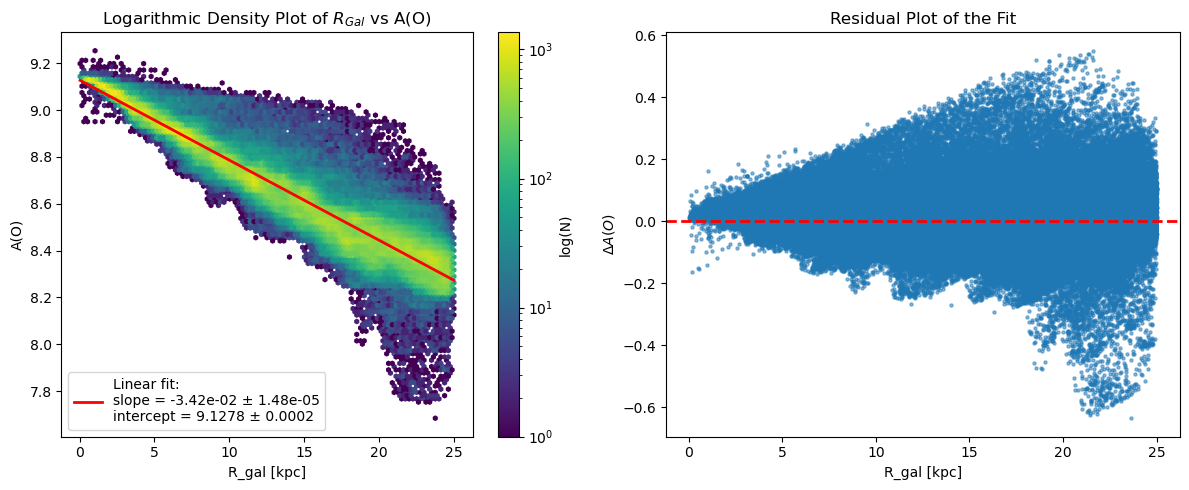

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

# ------------------------------
# 1. Load data
# ------------------------------
fits_file = '../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
with fits.open(fits_file) as hdul:
    data = hdul[1].data  # Assuming the table is in the first extension
    x = data['x']
    y = data['y']
    z = data['z']
    AO = data['A_O']  # Gas phase metallicity A(O)

# ------------------------------
# 2. Compute galactocentric radius (cylindrical coordinates)
# ------------------------------
R_gal = np.sqrt(x**2 + y**2)  # kpc

# ------------------------------
# 3. Define linear model and fit with curve_fit
# ------------------------------
def linear_model(R, m, b):
    """Linear model: A(O) = m*R + b"""
    return m * R + b

# Initial guesses for [slope, intercept]
p0 = [-0.01, 8.5]

# Fit
popt, pcov = curve_fit(linear_model, R_gal, AO, p0=p0)

# Extract best-fit parameters and uncertainties
slope, intercept = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))

print(f"Slope     = {slope:.2e} ± {slope_err:.2e}") # 4f
print(f"Intercept = {intercept:.4f} ± {intercept_err:.4f}") # 4f

# Compute fit line and residuals
AO_fit = linear_model(R_gal, slope, intercept)
residuals = AO - AO_fit

# ------------------------------
# 4. Plotting
# ------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Panel (a): Log density + fit
hb = axs[0].hexbin(R_gal, AO, gridsize=100, cmap='viridis', bins='log')
axs[0].plot(np.sort(R_gal), linear_model(np.sort(R_gal), slope, intercept),
            color='red', lw=2,
            label=(f'Linear fit:\n'
                   f'slope = {slope:.2e} ± {slope_err:.2e}\n'
                   f'intercept = {intercept:.4f} ± {intercept_err:.4f}'))
axs[0].set_xlabel('R_gal [kpc]')
axs[0].set_ylabel('A(O)')
axs[0].legend(loc='lower left')
axs[0].set_title("Logarithmic Density Plot of $R_{Gal}$ vs A(O)")
fig.colorbar(hb, ax=axs[0], label='log(N)')

# Panel (b): Residuals
axs[1].scatter(R_gal, residuals, s=5, alpha=0.5)
axs[1].axhline(0, color='red', lw=2, linestyle='--')
axs[1].set_xlabel('R_gal [kpc]')
axs[1].set_ylabel(r'$\Delta A(O)$')
axs[1].set_title("Residual Plot of the Fit")

# Save figure
plt.tight_layout()
plt.savefig('../figures/task3_radial_metallicity_2_panel.png', dpi=200)
plt.show()



### Fit details
I fitted a linear model of the form:

$$
A(O) = m R_{\text{Gal}} + b
$$

using `scipy.optimize.curve_fit`.  
The following hyperparameters were used:
- Initial parameter guesses: `p0 = [-0.01, 8.5]`
- Model type: linear (2 free parameters: slope and intercept)
- Default Levenberg–Marquardt algorithm (no bounds applied)

## Part 3


---- Goodness of Fit ----
RMS of residuals = 0.0726
R² = 0.9125
Largest residual scatter occurs around R ≈ 20.83 kpc


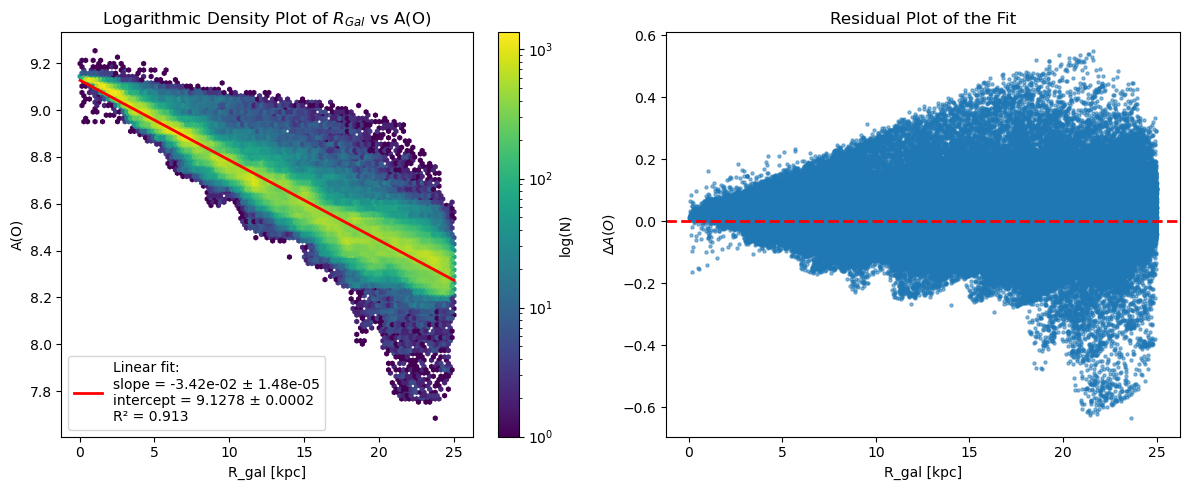

In [33]:
# ------------------------------
# 4. Statistical metrics
# ------------------------------
RMS = np.sqrt(np.mean(residuals**2))
SS_res = np.sum(residuals**2)
SS_tot = np.sum((AO - np.mean(AO))**2)
R2 = 1 - (SS_res / SS_tot)

print("\n---- Goodness of Fit ----")
print(f"RMS of residuals = {RMS:.4f}")
print(f"R² = {R2:.4f}")

# Identify region with larger residuals
R_bins = np.linspace(0, np.max(R_gal), 10)
res_bin_std = [np.std(residuals[(R_gal >= R_bins[i]) & (R_gal < R_bins[i+1])])
               for i in range(len(R_bins)-1)]
max_bin = np.argmax(res_bin_std)
print(f"Largest residual scatter occurs around R ≈ "
      f"{0.5*(R_bins[max_bin]+R_bins[max_bin+1]):.2f} kpc")

# ------------------------------
# 5. Plotting
# ------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Panel (a): log density + fit
hb = axs[0].hexbin(R_gal, AO, gridsize=100, cmap='viridis', bins='log')
axs[0].plot(np.sort(R_gal), linear_model(np.sort(R_gal), slope, intercept),
            color='red', lw=2,
            label=(f'Linear fit:\n'
                   f'slope = {slope:.2e} ± {slope_err:.2e}\n'
                   f'intercept = {intercept:.4f} ± {intercept_err:.4f}\n'
                   f'R² = {R2:.3f}'))
axs[0].set_xlabel('R_gal [kpc]')
axs[0].set_ylabel('A(O)')
axs[0].legend(loc='lower left')
axs[0].set_title("Logarithmic Density Plot of $R_{Gal}$ vs A(O)")
fig.colorbar(hb, ax=axs[0], label='log(N)')

# Panel (b): Residuals
axs[1].scatter(R_gal, residuals, s=5, alpha=0.5)
axs[1].axhline(0, color='red', lw=2, linestyle='--')
axs[1].set_xlabel('R_gal [kpc]')
axs[1].set_ylabel(r'$\Delta A(O)$')
axs[1].set_title("Residual Plot of the Fit")

plt.tight_layout()
plt.savefig('../figures/task3_radial_metallicity_2_panel.png', dpi=200)
plt.show()


The fitted linear model captures the overall negative metallicity gradient across the galactic disc with high accuracy. The goodness-of-fit metrics indicate that the model explains about 91% of the total variance (R² = 0.91) in the oxygen abundance, suggesting that a simple linear trend is an excellent first-order description of the metallicity distribution.

The root-mean-square (RMS) of the residuals is 0.073 dex, implying that the typical deviation of data points from the fitted line is small compared to the full range of A(O) values. The residual plot shows that the scatter is minimal at intermediate radii (∼5–15 kpc), where the metallicity gradient appears almost perfectly linear.

However, systematic deviations become noticeable toward both the inner (R < 5 kpc) and outer (R > 20 kpc) regions. In the centre, the residuals show a mild positive bias, indicating that the observed metallicities are slightly higher than predicted by the linear model. This is likely due to non-linear enrichment processes or central metallicity flattening often seen in simulations and observations. Conversely, at large radii (R > 20 kpc), the residual scatter increases substantially (as identified by the maximum residual standard deviation near R ≈ 20.8 kpc), reflecting either azimuthal variations or metallicity floor effects in the galactic outskirts where gas mixing is less efficient.

To improve the model's performance, several strategies can address the systematic errors shown in the residual plot. Implementing a piecewise regression would specifically handle the high-error region around R ≈ 20.83 kpc. Alternatively, the model's fundamental form could be enhanced by adding quadratic or higher-order terms to capture the evident curvature, or by applying nonlinear transformations. Finally, using weighted least squares would account for the heteroscedasticity and provide more robust parameter estimates. 

So, the linear model fits well across the mid-disc, providing a robust global gradient, but underperforms at the central and outermost regions where the physical processes deviate from simple linear scaling.

## Part 4

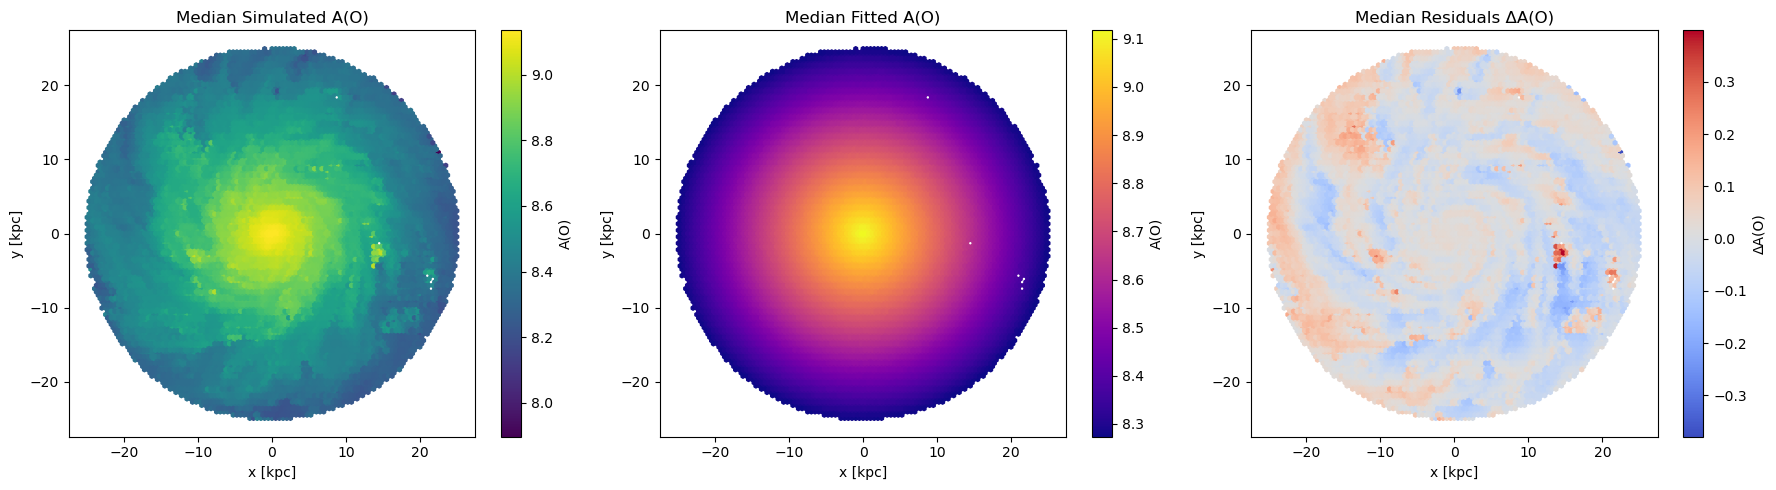

In [58]:
# ------------------------------
# Plotting 3-panel figure
# ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Panel (a): median simulated A(O)
hb0 = axs[0].hexbin(
    x, y, C=AO, reduce_C_function=np.median, gridsize=100, cmap='viridis'
)
axs[0].set_xlabel('x [kpc]')
axs[0].set_ylabel('y [kpc]')
axs[0].set_title('Median Simulated A(O)')
cb0 = fig.colorbar(hb0, ax=axs[0])
cb0.set_label('A(O)')

# Panel (b): median fitted A(O)
hb1 = axs[1].hexbin(
    x, y, C=AO_fit, reduce_C_function=np.median, gridsize=100, cmap='plasma'
)
axs[1].set_xlabel('x [kpc]')
axs[1].set_ylabel('y [kpc]')
axs[1].set_title('Median Fitted A(O)')
cb1 = fig.colorbar(hb1, ax=axs[1])
cb1.set_label('A(O)')

# Panel (c): median residuals
hb2 = axs[2].hexbin(
    x, y, C=residuals, reduce_C_function=np.median, gridsize=100, cmap='coolwarm'
)
axs[2].set_xlabel('x [kpc]')
axs[2].set_ylabel('y [kpc]')
axs[2].set_title('Median Residuals ΔA(O)')
cb2 = fig.colorbar(hb2, ax=axs[2])
cb2.set_label('ΔA(O)')

plt.tight_layout()
plt.savefig('../figures/task3_xy_median.png', dpi=200)
plt.show()


## Part 5

For the 3-panel x–y plane figure, I chose 100 × 100 bins (or gridsize=100 in hexbin). This provides a good balance between spatial resolution and statistical reliability in each bin:

**1. Fewer bins (low resolution):**<br>
If we reduce the number of bins, e.g., 40 × 40, each bin covers a larger area. <br>
Pros: Each bin has more points, so the median is more robust and less noisy. <br>
Cons: Small-scale variations in A(O) or residuals are smoothed out, and local structure is lost. Features like gradients, clumps, or substructures in the metallicity distribution would be missed.

**2. More bins (finer resolution):**<br>
If we increase the number of bins, e.g., 300 × 300, each bin covers a smaller area. <br>
Pros: We can resolve finer spatial details and detect subtle structures. <br>
Cons: Many bins will contain very few points (or be empty), making the median noisy or undefined. Low-density regions dominate the plot, and the color scale can be misleading.

**3. Chosen bin size (gridsize=100):**<br>
Each bin contains enough points to give a statistically meaningful median while still preserving visible spatial structures in the x–y plane. 
This choice of bin size highlights the main trends and residual patterns without being dominated by noise in sparsely populated regions. <br>
*Note:* There are a few visible undefined regions where bins contain very few or no points, but these are a minor effect and do not significantly affect the overall interpretation.

Below are two additional 3-panel histograms showing the effects of gridsizes of 40 and 300 respectively:

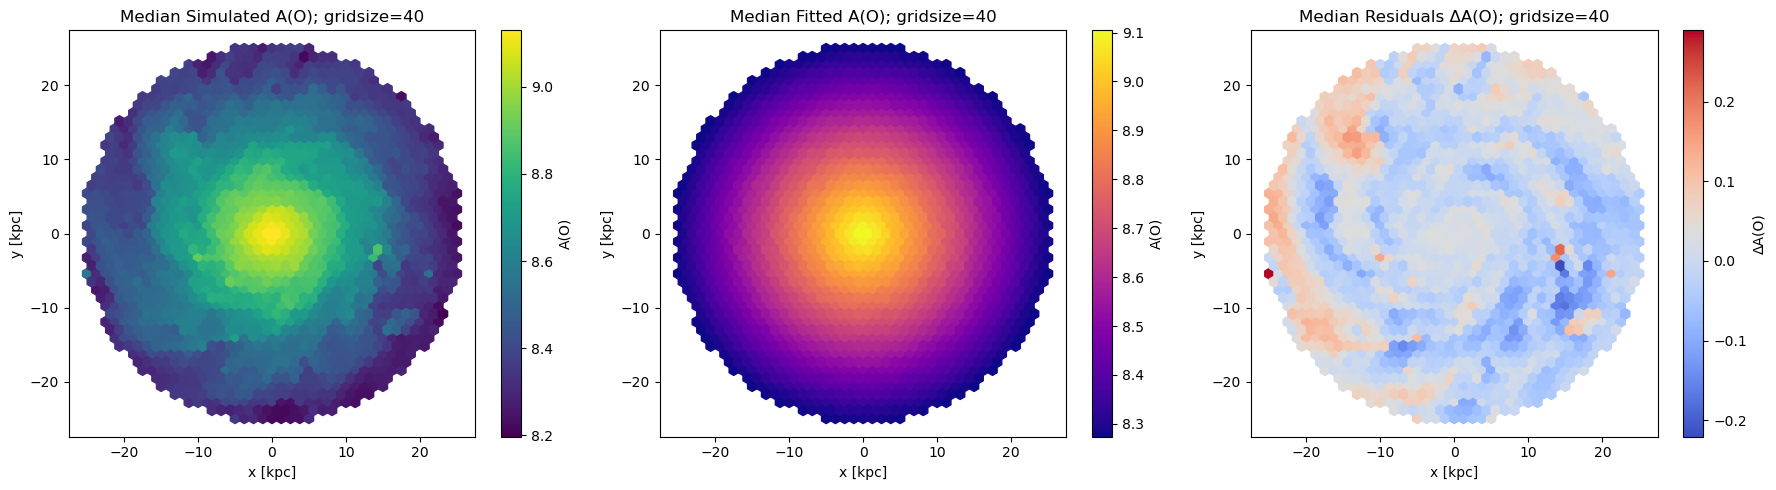

In [60]:
# ------------------------------
# 1. Plotting 3-panel figure (with gridsize of 40)
# ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Panel (a): median simulated A(O)
hb0 = axs[0].hexbin(
    x, y, C=AO, reduce_C_function=np.median, gridsize=40, cmap='viridis'
)
axs[0].set_xlabel('x [kpc]')
axs[0].set_ylabel('y [kpc]')
axs[0].set_title('Median Simulated A(O); gridsize=40')
cb0 = fig.colorbar(hb0, ax=axs[0])
cb0.set_label('A(O)')

# Panel (b): median fitted A(O)
hb1 = axs[1].hexbin(
    x, y, C=AO_fit, reduce_C_function=np.median, gridsize=40, cmap='plasma'
)
axs[1].set_xlabel('x [kpc]')
axs[1].set_ylabel('y [kpc]')
axs[1].set_title('Median Fitted A(O); gridsize=40')
cb1 = fig.colorbar(hb1, ax=axs[1])
cb1.set_label('A(O)')

# Panel (c): median residuals
hb2 = axs[2].hexbin(
    x, y, C=residuals, reduce_C_function=np.median, gridsize=40, cmap='coolwarm'
)
axs[2].set_xlabel('x [kpc]')
axs[2].set_ylabel('y [kpc]')
axs[2].set_title('Median Residuals ΔA(O); gridsize=40')
cb2 = fig.colorbar(hb2, ax=axs[2])
cb2.set_label('ΔA(O)')

plt.tight_layout()
plt.savefig('../figures/task3_xy_median_hexbin_gridsize50.png', dpi=200)
plt.show()

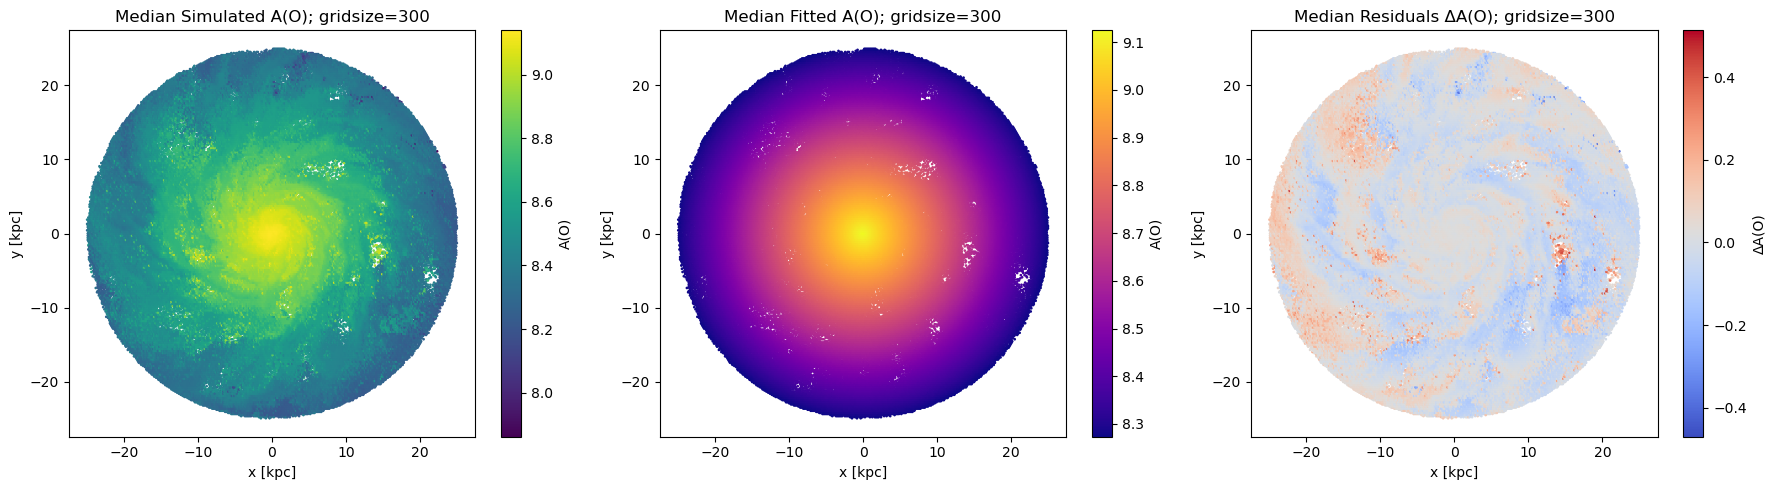

In [61]:
# ------------------------------
# 1. Plotting 3-panel figure (with gridzise of 300)
# ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Panel (a): median simulated A(O)
hb0 = axs[0].hexbin(
    x, y, C=AO, reduce_C_function=np.median, gridsize=300, cmap='viridis'
)
axs[0].set_xlabel('x [kpc]')
axs[0].set_ylabel('y [kpc]')
axs[0].set_title('Median Simulated A(O); gridsize=300')
cb0 = fig.colorbar(hb0, ax=axs[0])
cb0.set_label('A(O)')

# Panel (b): median fitted A(O)
hb1 = axs[1].hexbin(
    x, y, C=AO_fit, reduce_C_function=np.median, gridsize=300, cmap='plasma'
)
axs[1].set_xlabel('x [kpc]')
axs[1].set_ylabel('y [kpc]')
axs[1].set_title('Median Fitted A(O); gridsize=300')
cb1 = fig.colorbar(hb1, ax=axs[1])
cb1.set_label('A(O)')

# Panel (c): median residuals
hb2 = axs[2].hexbin(
    x, y, C=residuals, reduce_C_function=np.median, gridsize=300, cmap='coolwarm'
)
axs[2].set_xlabel('x [kpc]')
axs[2].set_ylabel('y [kpc]')
axs[2].set_title('Median Residuals ΔA(O); gridsize=300')
cb2 = fig.colorbar(hb2, ax=axs[2])
cb2.set_label('ΔA(O)')

plt.tight_layout()
plt.savefig('../figures/task3_xy_median_hexbin_gridsize200.png', dpi=200)
plt.show()

## Part 6

## git stuff

In [42]:
# git add task3/task3_radial_metallicity.ipynb
# git add .
# git commit -m "Add Task 3 notebook: radial metallicity relation with linear fit"
# # git push origin task2-gaia
# git push -u origin task3-python

In [43]:
# git checkout main
# git merge task2-gaia
# git push origin main
